In [192]:
# Python imports
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6)

def normalize(vec):
    return vec / np.linalg.norm(vec)

$\LaTeX$ definition block
$\newcommand{\sign}{\operatorname{sign}}$

# Distant Supervision

This notebook has a few cute experiments to explore distant supervision.

## Setup
In the distant supervision setting, we receive data $((x_i^a, x_i^b), y_i)$. Assuming the data is linearly separable with hyperplane $w^*$, we also are given that if $y_i = \sign[\max(w^{*\top} x_i^{a}, w^{*\top} x_i^{a})]$. Thus, if $y_i = -1$, we know that both $x^a_i$ and $x^b_i$ are in the negative class, but if $y_i = 1$, we only know that atleast one of $x^a_i$ or $x^b_i$ is positive.


## Data generation

Consider a random (unit) weights $w^*$.
We generate elements ${x_a, x_b}$, order $x_a$ by $w^* x_a$ and set $y_i$ to be $\sign[\max(w^{*\top} x_a, w^{*\top} x_b)]$.

In [193]:
# Constants
D = 2
N = 100
K = 2

In [194]:
w = np.random.randn(D)
w = normalize(w)
theta = np.arctan2(w[0], w[1])

X = np.random.randn(N,D,K)
y = np.zeros(N)
for i in range(N):
    m = w.dot(X[i])
    X[i] = X[i][:,np.argsort(-m)]
    y[i] = np.sign(max(m))

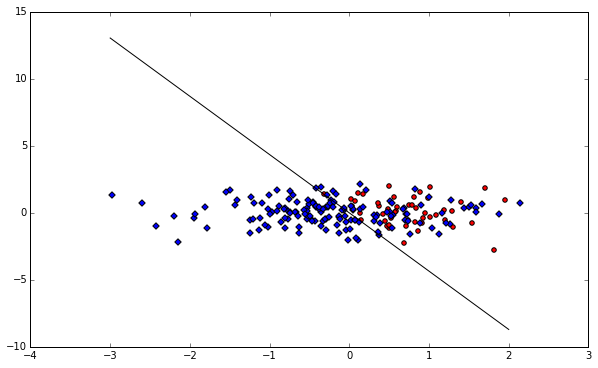

In [195]:
# Visualize data
plt.plot(np.arange(-3,3), -w[0]/w[1] * np.arange(-3,3), c='black')
plt.scatter(X[y<0,0,0], X[y<0,1,0], c='r', marker='o')
plt.scatter(X[y<0,0,1], X[y<0,1,1], c='r', marker='o')
plt.scatter(X[y>0,0,0], X[y>0,1,0], c='b', marker='D')
plt.scatter(X[y>0,0,1], X[y>0,1,1], c='b', marker='D')

In [196]:
# Split data for convenience
X_ = np.concatenate((X[y<0,:,0],X[y<0,:,1]))
Xa = X[y>0,:,0]
Xb = X[y>0,:,1]
Xp = np.concatenate((Xa, Xb))
Na, N_, Np = y[y>0].shape[0], 2*y[y<0].shape[0], 2*y[y>0].shape[0]
Nb = Na
Na, N_, Np

(76, 48, 152)

# Method

In [197]:
from cvxpy import *

## Exact SVM solution
Assuming we know what the positive points are.

In [198]:
# Beta is the coefficients, and e is the slack.
beta = Variable(D)
ea, e_ = Variable(Na), Variable(N_)
loss = 0.5 * norm(beta, 2) ** 2 + 1*sum_entries(e_)/N_ + 1* sum_entries(ea)/Na
constr = [mul_elemwise(-1,X_*beta) > 1 - e_, mul_elemwise(1,Xa*beta) > 1 - ea]
prob = Problem(Minimize(loss), constr)
print("loss", prob.solve())

w_ = np.array(beta.value).flatten()
w_ = w_ / np.linalg.norm(w_) # Until I add a 0.
print("error", np.linalg.norm(w-w_))

('loss', 0.8178485569764496)
('error', 0.11421171229841975)


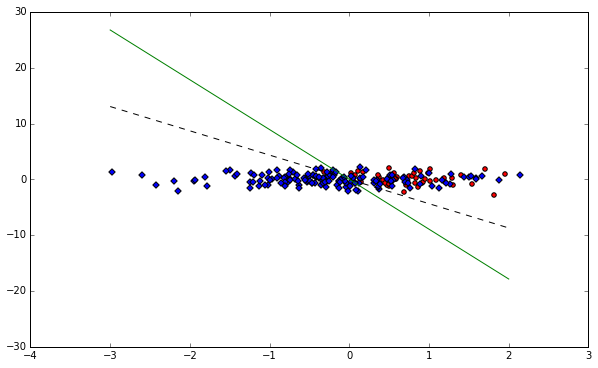

In [199]:
# Visualize data
plt.plot(np.arange(-3,3), -w[0]/w[1] * np.arange(-3,3), linestyle='dashed', c='black')
plt.plot(np.arange(-3,3), -w_[0]/w_[1] * np.arange(-3,3), c='green')
plt.scatter(X[y<0,0,0], X[y<0,1,0], c='r', marker='o')
plt.scatter(X[y<0,0,1], X[y<0,1,1], c='r', marker='o')
plt.scatter(X[y>0,0,0], X[y>0,1,0], c='b', marker='D')
plt.scatter(X[y>0,0,1], X[y>0,1,1], c='b', marker='D')

## Naive
Assumes that all positive data is the same.

In [200]:
# Beta is the coefficients, and e is the slack.
beta = Variable(D)
ep, e_ = Variable(Np), Variable(N_)
loss = 0.5 * norm(beta, 2) ** 2 + 1*sum_entries(e_)/N_ + 1* sum_entries(ep)/Np
constr = [mul_elemwise(-1,X_*beta) > 1 - e_, mul_elemwise(1,Xp*beta) > 1 - ep]
prob = Problem(Minimize(loss), constr)
print("loss", prob.solve())

w_ = np.array(beta.value).flatten()
w_ = w_ / np.linalg.norm(w_) # Until I add a 0.
print("error", np.linalg.norm(w-w_))

('loss', 1.5137985823022353)
('error', 0.10553767911889485)


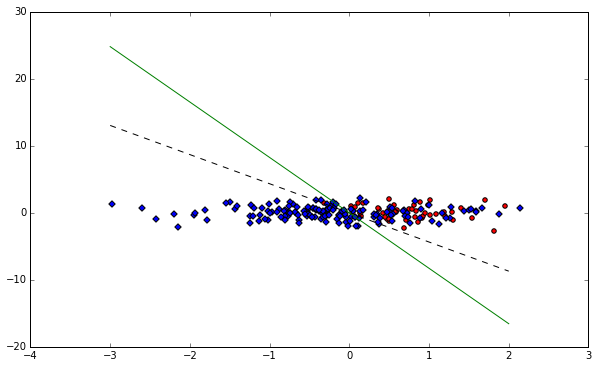

In [201]:
# Visualize data
plt.plot(np.arange(-3,3), -w[0]/w[1] * np.arange(-3,3), linestyle='dashed', c='black')
plt.plot(np.arange(-3,3), -w_[0]/w_[1] * np.arange(-3,3), c='green')
plt.scatter(X[y<0,0,0], X[y<0,1,0], c='r', marker='o')
plt.scatter(X[y<0,0,1], X[y<0,1,1], c='r', marker='o')
plt.scatter(X[y>0,0,0], X[y>0,1,0], c='b', marker='D')
plt.scatter(X[y>0,0,1], X[y>0,1,1], c='b', marker='D')

As expected, the naive approach does really poorly.

## Proposed method
Incorporate responsibilities for the points.

$\begin{align*}
\min{}& \frac{1}{2} \|\beta\|^2 + C \xi \\
\textrm{subject to}
& -1(\beta^\top x_{-}) \ge 1 - \xi \\
& +1(\beta^\top x_{a}) \ge y_a - \xi \\
& +1(\beta^\top x_{b}) \ge y_b - \xi \\
& y_a > 0, y_b > 0, y_a + y_b \ge 1
\end{align*}$

In [202]:
# Beta is the coefficients, and e is the slack.
Da, = y[y>0].shape
beta = Variable(D)
e = Variable()
loss = 0.5 * norm(beta, 2) ** 2 + 1 * e
constr = [mul_elemwise(-1,X_*beta) > 1 - e,
          Xa*beta + Xb*beta > 1 - e,
         ]
prob = Problem(Minimize(loss), constr)
print("loss", prob.solve())

w_ = np.array(beta.value).flatten()
w_ = w_ / np.linalg.norm(w_) # Until I add a 0.
print("error", np.linalg.norm(w-w_))

('loss', 1.0000000000009073)
('error', 0.0022340641704992059)


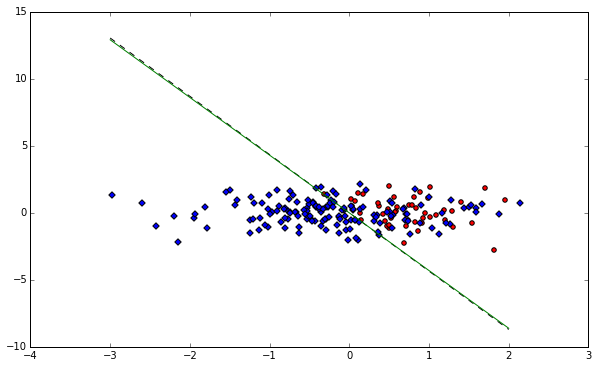

In [203]:
# Visualize data
plt.plot(np.arange(-3,3), -w[0]/w[1] * np.arange(-3,3), linestyle='dashed', c='black')
plt.plot(np.arange(-3,3), -w_[0]/w_[1] * np.arange(-3,3), c='green')
plt.scatter(X[y<0,0,0], X[y<0,1,0], c='r', marker='o')
plt.scatter(X[y<0,0,1], X[y<0,1,1], c='r', marker='o')
plt.scatter(X[y>0,0,0], X[y>0,1,0], c='b', marker='D')
plt.scatter(X[y>0,0,1], X[y>0,1,1], c='b', marker='D')

# Proposed 2

In [204]:
# Beta is the coefficients, and e is the slack.
Da, = y[y>0].shape
beta = Variable(D)
e = Variable()
C = 1.
C_ = 1
loss = 0.5 * norm(beta, 2) ** 2 + C * e + C_ * sum_entries(pos(Xa*beta) + pos(Xb*beta) - 1) / Na
constr = [mul_elemwise(-1,X_*beta) > 1 - e,
         ]
prob = Problem(Minimize(loss), constr)
print("loss", prob.solve())

w_ = np.array(beta.value).flatten()
w_ = w_ / np.linalg.norm(w_) # Until I add a 0.
print("error", np.linalg.norm(w-w_))

('loss', 1.5720758028692217e-13)
('error', 0.026847894513781105)


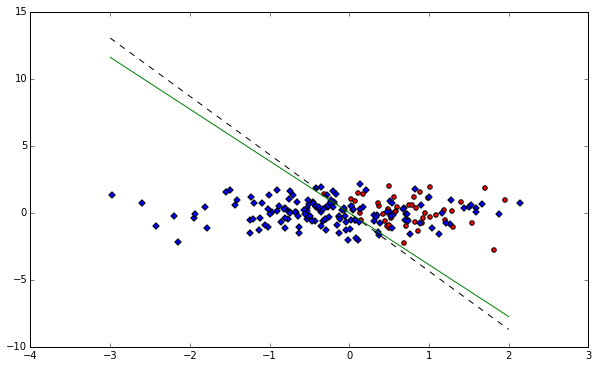

In [205]:
# Visualize data
plt.plot(np.arange(-3,3), -w[0]/w[1] * np.arange(-3,3), linestyle='dashed', c='black')
plt.plot(np.arange(-3,3), -w_[0]/w_[1] * np.arange(-3,3), c='green')
plt.scatter(X[y<0,0,0], X[y<0,1,0], c='r', marker='o')
plt.scatter(X[y<0,0,1], X[y<0,1,1], c='r', marker='o')
plt.scatter(X[y>0,0,0], X[y>0,1,0], c='b', marker='D')
plt.scatter(X[y>0,0,1], X[y>0,1,1], c='b', marker='D')